In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (16, 8.27)  #set graphs size to A4 dimensions
sns.set_style('darkgrid')
sns.set(font_scale=1.4)

In [2]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Dataset loading and stats

In [3]:
# dataset = pd.read_csv('../works/data/adult.csv')
dataset = pd.read_csv('../works/data/housing.csv')

In [7]:
# col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education-num','marital-status', 'occupation','relationship',
#               'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
col_labels = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
              'households', 'median_income',
              'median_house_value', 'ocean_proximity']

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
#find out numerical and categorical features for train set

numerical_features = [feature for feature in dataset.columns if dataset[feature].dtype != 'O']
categorical_features = [feature for feature in dataset.columns if dataset[feature].dtype == 'O' and feature != 'income']

print('categorical features: ''\n', categorical_features)
print('\n')
print('numerical features: ''\n', numerical_features)

categorical features: 
 ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


numerical features: 
 ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [6]:
#Check for missing values
dataset.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [9]:
#Find out distinct values for each numerical feature
for feature in numerical_features:
    print(feature, ':', dataset[feature].nunique())

age : 74
fnlwgt : 28523
educational-num : 16
capital-gain : 123
capital-loss : 99
hours-per-week : 96


In [10]:
#Find out distinct values for each categorical feature
for feature in categorical_features:
    print(feature, ':', dataset[feature].nunique())

workclass : 9
education : 16
marital-status : 7
occupation : 15
relationship : 6
race : 5
gender : 2
native-country : 42


In [11]:
#Check for imbalanced target (In our case 76% are in class <=50K and 24% >50K)
dataset['income'].value_counts('f')

<=50K    0.760718
>50K     0.239282
Name: income, dtype: float64

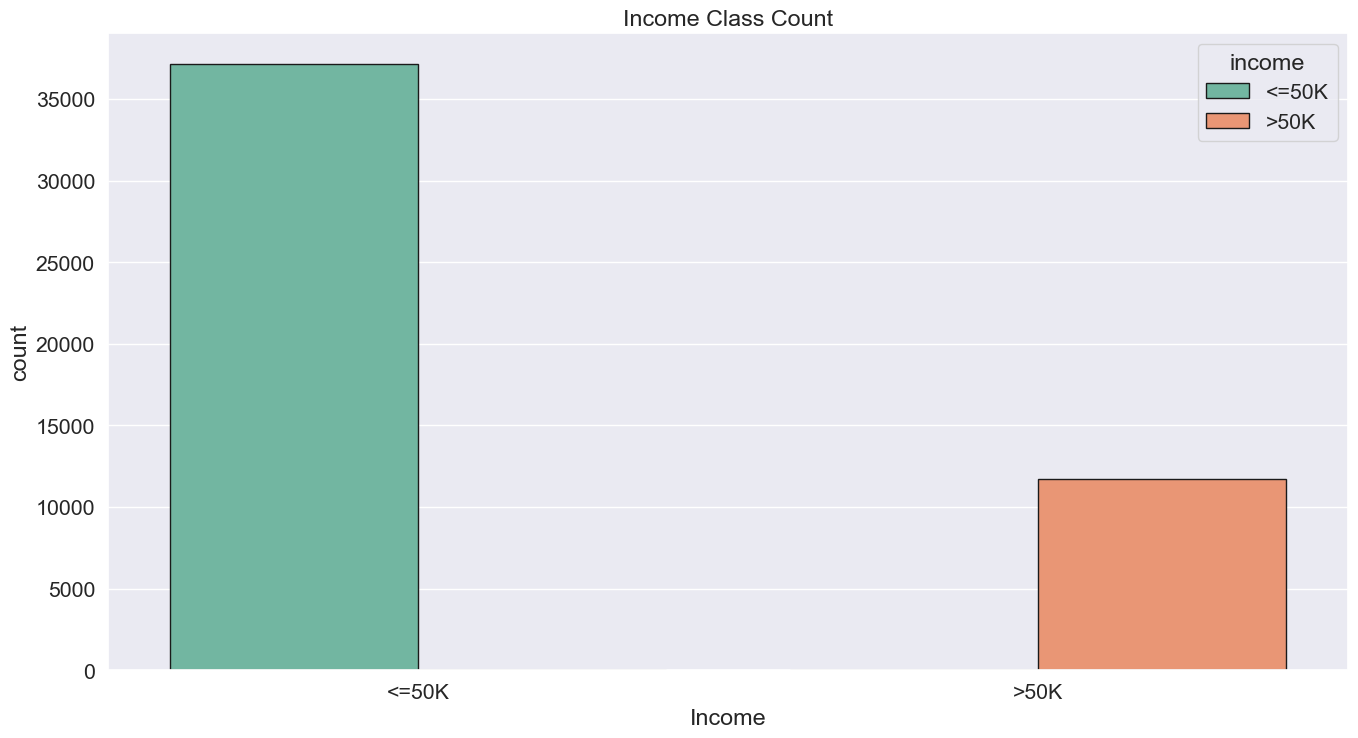

In [12]:
ax = sns.countplot(x=dataset['income'], hue=dataset['income'], edgecolor='k', palette='Set2')
ax.set_title('Income Class Count')
ax.set_xlabel('Income')
plt.show()

# Non-balanced, numerical only dataset and experiments

In [13]:
n_balanced_dataset = dataset.copy()
n_balanced_dataset['income'] = n_balanced_dataset['income'].map({'<=50K': 0, '<=50K.': 0, '>50K': 1, '>50K': 1})
n_balanced_dataset['workclass'] = n_balanced_dataset['workclass'].replace(['?'], 'Unknown')
n_balanced_dataset['marital-status'] = n_balanced_dataset['marital-status'].replace(
    ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 'Married')
n_balanced_dataset['marital-status'] = n_balanced_dataset['marital-status'].replace(
    ['Never-married', 'Divorced', 'Separated', 'Widowed'],
    'Single')
n_balanced_dataset['marital-status'] = n_balanced_dataset['marital-status'].map({'Married': 0, 'Single': 1})
n_balanced_dataset['marital-status'] = n_balanced_dataset['marital-status']
n_balanced_dataset.drop(
    labels=['gender', 'workclass', 'education', 'occupation', 'relationship', 'race', 'native-country'],
    axis=1, inplace=True)

In [14]:
n_balanced_dataset.head(10)

,age,fnlwgt,educational-num,marital-status,capital-gain,capital-loss,hours-per-week,income
0,25,226802,7,1,0,0,40,0
1,38,89814,9,0,0,0,50,0
2,28,336951,12,0,0,0,40,1
3,44,160323,10,0,7688,0,40,1
4,18,103497,10,1,0,0,30,0
5,34,198693,6,1,0,0,30,0
6,29,227026,9,1,0,0,40,0
7,63,104626,15,0,3103,0,32,1
8,24,369667,10,1,0,0,40,0
9,55,104996,4,0,0,0,10,0


In [15]:
Y = n_balanced_dataset.income
n_balanced_dataset.drop(labels=['income'], axis=1, inplace=True)
n_balanced_dataset.head(5)

,age,fnlwgt,educational-num,marital-status,capital-gain,capital-loss,hours-per-week
0,25,226802,7,1,0,0,40
1,38,89814,9,0,0,0,50
2,28,336951,12,0,0,0,40
3,44,160323,10,0,7688,0,40
4,18,103497,10,1,0,0,30


In [16]:
n_X_train, n_X_test, n_y_train, n_y_test = train_test_split(n_balanced_dataset, Y, test_size=0.2, random_state=0)

In [17]:
n_balanced_model = XGBClassifier()

In [18]:
n_balanced_model.fit(n_X_train, n_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [19]:
n_y_pred = n_balanced_model.predict(n_X_test)

In [20]:
print(classification_report(n_y_test, n_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7420
           1       0.77      0.60      0.68      2349

    accuracy                           0.86      9769
   macro avg       0.83      0.77      0.79      9769
weighted avg       0.86      0.86      0.85      9769



In [21]:
print(accuracy_score(n_y_test, n_y_pred))

0.8609888422561163


# Balanced set and experiments

In [22]:
balanced_dataset = dataset.copy()
balanced_dataset.head(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## Data preprocessing

In [23]:
#convert <=50K and >50K to 0, 1 respectively
encoder = LabelEncoder()
balanced_dataset['income'] = encoder.fit_transform(balanced_dataset['income'])
balanced_dataset.head(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


In [24]:
#transform country feature to be 1 if country is the United States. Otherwise is equal to 0
balanced_dataset['native-country'] = np.where(balanced_dataset['native-country'] == 'United-States', 1, 0)
#transform marital status and concatenate some classes to reduce distinct classes
balanced_dataset['marital-status'] = balanced_dataset['marital-status'].replace(
    {' Married-civ-spouse': 'Married', ' Never-married': 'Single',
     ' Separated': 'Divorced', ' Married-spouse-absent': 'Divorced',
     ' Divorced': 'Divorced',
     ' Married-AF-spouse': 'Divorced', ' Widowed': 'Widowed'})
#transform workclass feature to be 1 if the workclass is Private and 0 if doesn't
balanced_dataset['workclass'] = np.where(balanced_dataset['workclass'] == 'Private', 1, 0)
#transform workclass feature to be 1 if the Sex is Male and 0 if doesn't
balanced_dataset['gender'] = np.where(balanced_dataset['gender'] == 'Male', 1, 0)
#transform workclass feature to be 1 if the Race is White and 0 if doesn't
balanced_dataset['race'] = np.where(balanced_dataset['race'] == 'White', 1, 0)

In [25]:
#create ordered label for education
education_mapping = {'Preschool': 0, '1st-4th': 1, '5th-6th': 2, '7th-8th': 3, '9th': 4, '10th': 5,
                     '11th': 6, '12th': 7, 'HS-grad': 8, 'Some-college': 0, 'Assoc-acdm': 10,
                     'Assoc-voc': 11, 'Bachelors': 12, 'Prof-school': 13, 'Masters': 14, 'Doctorate': 15
                     }
balanced_dataset['education'] = balanced_dataset['education'].map(education_mapping)

In [26]:
relationship_ordered = balanced_dataset.groupby(['relationship'])['income'].count().sort_values().index
relationship_ordered = {k: i for i, k in enumerate(relationship_ordered, 0)}
balanced_dataset['relationship'] = balanced_dataset['relationship'].map(relationship_ordered)

In [27]:
occupation_ordered = balanced_dataset.groupby(['occupation'])['income'].count().sort_values().index
occupation_ordered = {k: i for i, k in enumerate(occupation_ordered, 0)}
balanced_dataset['occupation'] = balanced_dataset['occupation'].map(occupation_ordered)

In [28]:
marital_ordered = balanced_dataset.groupby(['marital-status'])['income'].count().sort_values().index
marital_ordered = {k: i for i, k in enumerate(marital_ordered, 0)}
balanced_dataset['marital-status'] = balanced_dataset['marital-status'].map(marital_ordered)

In [29]:
balanced_dataset.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,1,226802,6,7,5,8,3,0,1,0,0,40,1,0
1,38,1,89814,8,9,6,4,5,1,1,0,0,50,1,0
2,28,0,336951,10,12,6,2,5,1,1,0,0,40,1,1
3,44,1,160323,0,10,6,8,5,0,1,7688,0,40,1,1
4,18,0,103497,0,10,5,7,3,1,0,0,0,30,1,0
5,34,1,198693,5,6,5,9,4,1,1,0,0,30,1,0
6,29,0,227026,8,9,5,7,2,0,1,0,0,40,1,0
7,63,0,104626,13,15,6,14,5,1,1,3103,0,32,1,1
8,24,1,369667,0,10,5,9,2,1,0,0,0,40,1,0
9,55,1,104996,3,4,6,13,5,1,1,0,0,10,1,0


In [30]:
balanced_dataset.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [31]:
balanced_dataset.drop('fnlwgt', axis=1, inplace=True)  # it is not a useful feature for predicting the wage class

In [32]:
#scaling the train set with StandardScaler
scaler = StandardScaler()
scaled_features_balanced_dataset = scaler.fit_transform(balanced_dataset.drop('income', axis=1))
scaled_features_balanced_dataset = pd.DataFrame(scaled_features_balanced_dataset,
                                                columns=balanced_dataset.drop('income', axis=1).columns)

In [33]:
#undersampling the train set
under = OneSidedSelection()
X_train_res, y_train_res = under.fit_resample(scaled_features_balanced_dataset, balanced_dataset['income'])

#oversampling the train set
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train_res, y_train_res)

X_train_res = pd.DataFrame(X_train_res, columns=balanced_dataset.drop('income', axis=1).columns)

#creating the final train
final_balanced_dataset = pd.concat([X_train_res, y_train_res], axis=1)

In [34]:
dataset = pd.read_csv('../works/data/adult.csv')
encoder = LabelEncoder()
dataset['income'] = encoder.fit_transform(dataset['income'])
dataset['native-country'] = np.where(dataset['native-country'] == 'United-States', 1, 0)
dataset['marital-status'] = dataset['marital-status'].replace(
    {' Married-civ-spouse': 'Married', ' Never-married': 'Single',
     ' Separated': 'Divorced', ' Married-spouse-absent': 'Divorced',
     ' Divorced': 'Divorced',
     ' Married-AF-spouse': 'Divorced', ' Widowed': 'Widowed'})
dataset['workclass'] = np.where(dataset['workclass'] == 'Private', 1, 0)
dataset['gender'] = np.where(dataset['gender'] == 'Male', 1, 0)
dataset['race'] = np.where(dataset['race'] == 'White', 1, 0)
education_mapping = {'Preschool': 0, '1st-4th': 1, '5th-6th': 2, '7th-8th': 3, '9th': 4, '10th': 5,
                     '11th': 6, '12th': 7, 'HS-grad': 8, 'Some-college': 0, 'Assoc-acdm': 10,
                     'Assoc-voc': 11, 'Bachelors': 12, 'Prof-school': 13, 'Masters': 14, 'Doctorate': 15
                     }
dataset['education'] = dataset['education'].map(education_mapping)
relationship_ordered = dataset.groupby(['relationship'])['income'].count().sort_values().index
relationship_ordered = {k: i for i, k in enumerate(relationship_ordered, 0)}
dataset['relationship'] = dataset['relationship'].map(relationship_ordered)
occupation_ordered = dataset.groupby(['occupation'])['income'].count().sort_values().index
occupation_ordered = {k: i for i, k in enumerate(occupation_ordered, 0)}
dataset['occupation'] = dataset['occupation'].map(occupation_ordered)
marital_ordered = dataset.groupby(['marital-status'])['income'].count().sort_values().index
marital_ordered = {k: i for i, k in enumerate(marital_ordered, 0)}
dataset['marital-status'] = dataset['marital-status'].map(marital_ordered)
dataset.drop('fnlwgt', axis=1, inplace=True)  # it is not a useful feature for predicting the wage class
scaler = StandardScaler()
scaled_features_balanced_dataset = scaler.fit_transform(dataset.drop('income', axis=1))
scaled_features_balanced_dataset = pd.DataFrame(scaled_features_balanced_dataset,
                                                columns=dataset.drop('income', axis=1).columns)
# undersampling the train set
under = OneSidedSelection()
x_train_res, y_train_res = under.fit_resample(scaled_features_balanced_dataset, dataset['income'])

# oversampling the train set
sm = SMOTE()
x_train_res, y_train_res = sm.fit_resample(x_train_res, y_train_res)

x_train_res = pd.DataFrame(x_train_res, columns=dataset.drop('income', axis=1).columns)

# creating the final train
final_balanced_dataset = pd.concat([x_train_res, y_train_res], axis=1)

In [35]:
final_balanced_dataset.head(10)

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,1.411808,0.663711,-1.104616,-2.753106,0.807497,-1.786217,0.902898,0.411743,0.70422,-0.144804,-0.217127,-0.034087,-2.957854,0
1,-0.995129,0.663711,-0.241697,-1.197259,-0.101107,-0.563611,-0.567717,-2.428701,0.70422,-0.144804,-0.217127,-0.034087,0.338083,0
2,-0.046942,0.663711,0.189763,-0.419335,0.807497,-1.786217,0.902898,0.411743,0.70422,-0.144804,-0.217127,0.772930,0.338083,0
3,-1.505691,-1.506680,-1.536076,-0.030373,-0.101107,-0.869262,-0.567717,0.411743,-1.42001,-0.144804,-0.217127,-0.841104,0.338083,0
4,-0.338691,0.663711,-0.457427,-1.586221,-0.101107,-0.257960,0.167590,0.411743,0.70422,-0.144804,-0.217127,-0.841104,0.338083,0
5,-0.703379,-1.506680,0.189763,-0.419335,-0.101107,-0.869262,-1.303025,-2.428701,0.70422,-0.144804,-0.217127,-0.034087,0.338083,0
6,-1.068066,0.663711,-1.536076,-0.030373,-0.101107,-0.257960,-1.303025,0.411743,-1.42001,-0.144804,-0.217127,-0.034087,0.338083,0
7,1.192996,0.663711,-0.888886,-2.364144,0.807497,0.964646,0.902898,0.411743,0.70422,-0.144804,-0.217127,-2.455137,0.338083,0
8,-0.192816,-1.506680,1.052682,1.136512,0.807497,0.353343,0.902898,0.411743,0.70422,-0.144804,-0.217127,-0.034087,0.338083,0
9,-0.922191,0.663711,0.189763,-0.419335,-0.101107,0.353343,0.167590,0.411743,-1.42001,-0.144804,-0.217127,-0.114789,0.338083,0


In [36]:
final_balanced_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71300 entries, 0 to 71299
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              71300 non-null  float64
 1   workclass        71300 non-null  float64
 2   education        71300 non-null  float64
 3   educational-num  71300 non-null  float64
 4   marital-status   71300 non-null  float64
 5   occupation       71300 non-null  float64
 6   relationship     71300 non-null  float64
 7   race             71300 non-null  float64
 8   gender           71300 non-null  float64
 9   capital-gain     71300 non-null  float64
 10  capital-loss     71300 non-null  float64
 11  hours-per-week   71300 non-null  float64
 12  native-country   71300 non-null  float64
 13  income           71300 non-null  int32  
dtypes: float64(13), int32(1)
memory usage: 7.3 MB


In [37]:
final_balanced_dataset['income'].value_counts()  #now train set is balanced

0    35650
1    35650
Name: income, dtype: int64

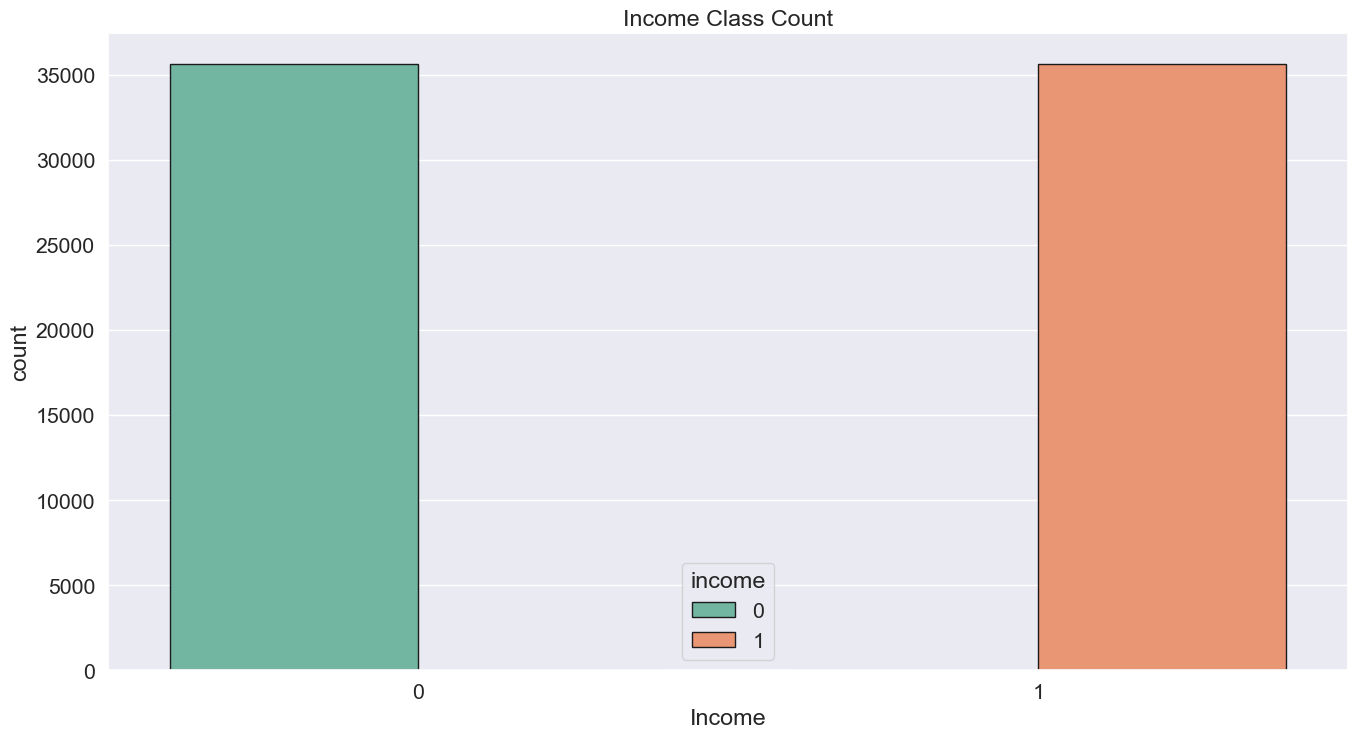

In [38]:
ax = sns.countplot(x=final_balanced_dataset['income'], hue=final_balanced_dataset['income'], edgecolor='k',
                   palette='Set2')
ax.set_title('Income Class Count')
ax.set_xlabel('Income')
plt.show()

In [39]:
balanced_Y = final_balanced_dataset.income
final_balanced_dataset.drop(labels=['income'], axis=1, inplace=True)
final_balanced_dataset.head(5)

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,1.411808,0.663711,-1.104616,-2.753106,0.807497,-1.786217,0.902898,0.411743,0.70422,-0.144804,-0.217127,-0.034087,-2.957854
1,-0.995129,0.663711,-0.241697,-1.197259,-0.101107,-0.563611,-0.567717,-2.428701,0.70422,-0.144804,-0.217127,-0.034087,0.338083
2,-0.046942,0.663711,0.189763,-0.419335,0.807497,-1.786217,0.902898,0.411743,0.70422,-0.144804,-0.217127,0.772930,0.338083
3,-1.505691,-1.506680,-1.536076,-0.030373,-0.101107,-0.869262,-0.567717,0.411743,-1.42001,-0.144804,-0.217127,-0.841104,0.338083
4,-0.338691,0.663711,-0.457427,-1.586221,-0.101107,-0.257960,0.167590,0.411743,0.70422,-0.144804,-0.217127,-0.841104,0.338083


In [40]:
final_balanced_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71300 entries, 0 to 71299
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              71300 non-null  float64
 1   workclass        71300 non-null  float64
 2   education        71300 non-null  float64
 3   educational-num  71300 non-null  float64
 4   marital-status   71300 non-null  float64
 5   occupation       71300 non-null  float64
 6   relationship     71300 non-null  float64
 7   race             71300 non-null  float64
 8   gender           71300 non-null  float64
 9   capital-gain     71300 non-null  float64
 10  capital-loss     71300 non-null  float64
 11  hours-per-week   71300 non-null  float64
 12  native-country   71300 non-null  float64
dtypes: float64(13)
memory usage: 7.1 MB


In [41]:
balanced_X_train, balanced_X_test, balanced_y_train, balanced_y_test = train_test_split(final_balanced_dataset,
                                                                                        balanced_Y, test_size=0.2,
                                                                                        random_state=0)

In [42]:
balanced_model = XGBClassifier()

In [43]:
balanced_model.fit(balanced_X_train, balanced_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [44]:
balanced_y_pred = balanced_model.predict(balanced_X_test)

# Balanced / not balanced outcome comparision

In [45]:
print(classification_report(n_y_test, n_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7420
           1       0.77      0.60      0.68      2349

    accuracy                           0.86      9769
   macro avg       0.83      0.77      0.79      9769
weighted avg       0.86      0.86      0.85      9769



In [46]:
print(accuracy_score(n_y_test, n_y_pred))

0.8609888422561163


In [47]:
print(classification_report(balanced_y_test, balanced_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      7008
           1       0.90      0.91      0.91      7252

    accuracy                           0.91     14260
   macro avg       0.91      0.91      0.91     14260
weighted avg       0.91      0.91      0.91     14260



In [48]:
print(accuracy_score(balanced_y_test, balanced_y_pred))

0.9053997194950911
